# Comprehensive CKD Model Training and Comparison

This notebook trains 5 ML models on both CKD datasets and provides a comprehensive comparison report.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, validation_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                           roc_curve, accuracy_score, precision_score, recall_score, f1_score)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load and Examine Datasets (First 2 Rows Only)

In [2]:
# Load both datasets
df1 = pd.read_csv('kidney_disease.csv')
df2 = pd.read_csv('Chronic_Kidney_Dsease_data.csv')

print("Dataset 1 (kidney_disease.csv):")
print(f"Shape: {df1.shape}")
print("First 2 rows:")
print(df1.head(2))

print("\n" + "="*80)
print("Dataset 2 (Chronic_Kidney_Dsease_data.csv):")
print(f"Shape: {df2.shape}")
print("First 2 rows:")
print(df2.head(2))

Dataset 1 (kidney_disease.csv):
Shape: (400, 26)
First 2 rows:
   id   age    bp    sg   al   su  rbc      pc         pcc          ba  ...  \
0   0  48.0  80.0  1.02  1.0  0.0  NaN  normal  notpresent  notpresent  ...   
1   1   7.0  50.0  1.02  4.0  0.0  NaN  normal  notpresent  notpresent  ...   

   pcv    wc   rc  htn   dm  cad appet  pe ane classification  
0   44  7800  5.2  yes  yes   no  good  no  no            ckd  
1   38  6000  NaN   no   no   no  good  no  no            ckd  

[2 rows x 26 columns]

Dataset 2 (Chronic_Kidney_Dsease_data.csv):
Shape: (1659, 54)
First 2 rows:
   PatientID  Age  Gender  Ethnicity  SocioeconomicStatus  EducationLevel  \
0          1   71       0          0                    0               2   
1          2   34       0          0                    1               3   

         BMI  Smoking  AlcoholConsumption  PhysicalActivity  ...   Itching  \
0  31.069414        1            5.128112          1.676220  ...  7.556302   
1  29.692119       

## 2. Data Preprocessing Functions

In [3]:
def preprocess_dataset1(df):
    """Preprocess the kidney_disease.csv dataset"""
    df_processed = df.copy()

    # Remove ID column
    if 'id' in df_processed.columns:
        df_processed = df_processed.drop('id', axis=1)

    # Clean target variable
    df_processed['classification'] = df_processed['classification'].str.strip()
    df_processed['classification'] = df_processed['classification'].replace('ckd\t', 'ckd')

    # Define categorical and numerical columns
    categorical_cols = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
    numerical_cols = ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']

    # Handle missing values
    df_processed = df_processed.replace(['?', '', ' '], np.nan)

    # Convert numerical columns
    for col in numerical_cols:
        if col in df_processed.columns:
            df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')

    # Clean categorical columns
    for col in categorical_cols:
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].astype(str).str.strip().str.lower()
            df_processed[col] = df_processed[col].replace('nan', np.nan)

    # Impute missing values
    num_imputer = SimpleImputer(strategy='median')
    df_processed[numerical_cols] = num_imputer.fit_transform(df_processed[numerical_cols])

    for col in categorical_cols:
        if col in df_processed.columns:
            mode_value = df_processed[col].mode()[0] if not df_processed[col].mode().empty else 'unknown'
            df_processed[col] = df_processed[col].fillna(mode_value)

    # Encode categorical variables
    le = LabelEncoder()
    for col in categorical_cols:
        if col in df_processed.columns:
            df_processed[col] = le.fit_transform(df_processed[col])

    # Encode target variable
    df_processed['target'] = (df_processed['classification'] == 'ckd').astype(int)

    return df_processed

def preprocess_dataset2(df):
    """Preprocess the Chronic_Kidney_Dsease_data.csv dataset"""
    df_processed = df.copy()

    # Remove non-predictive columns
    cols_to_drop = ['PatientID', 'DoctorInCharge']
    for col in cols_to_drop:
        if col in df_processed.columns:
            df_processed = df_processed.drop(col, axis=1)

    # Handle missing values
    numeric_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
    if 'Diagnosis' in numeric_cols:
        numeric_cols.remove('Diagnosis')

    # Impute numeric columns
    if numeric_cols:
        imputer = SimpleImputer(strategy='median')
        df_processed[numeric_cols] = imputer.fit_transform(df_processed[numeric_cols])

    # Create target variable based on clinical indicators
    conditions = []
    if 'SerumCreatinine' in df_processed.columns:
        conditions.append(df_processed['SerumCreatinine'] > 1.5)
    if 'GFR' in df_processed.columns:
        conditions.append(df_processed['GFR'] < 60)
    if 'ProteinInUrine' in df_processed.columns:
        conditions.append(df_processed['ProteinInUrine'] > 0.5)

    if conditions:
        df_processed['target'] = np.any(conditions, axis=0).astype(int)
    else:
        # Create synthetic target based on multiple clinical indicators
        np.random.seed(42)
        df_processed['target'] = np.random.binomial(1, 0.3, len(df_processed))

    return df_processed

print("Preprocessing functions defined successfully!")

Preprocessing functions defined successfully!


In [4]:
# Enhanced validation functions to prevent overfitting
def check_data_quality(df, dataset_name):
    print(f"\n=== Data Quality Check for {dataset_name} ===")
    class_dist = df['target'].value_counts()
    print(f"Class distribution: {class_dist.to_dict()}")
    minority_ratio = min(class_dist) / sum(class_dist)
    print(f"Minority class ratio: {minority_ratio:.3f}")
    if minority_ratio < 0.1:
        print("⚠️  WARNING: Severe class imbalance!")
    return minority_ratio

def get_regularized_models():
    return {
        'Random Forest': RandomForestClassifier(
            n_estimators=100, max_depth=10, min_samples_split=10,
            min_samples_leaf=5, random_state=42
        ),
        'Logistic Regression': LogisticRegression(C=1.0, random_state=42, max_iter=1000),
        'SVM': SVC(C=1.0, gamma='scale', random_state=42, probability=True),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100, max_depth=6, learning_rate=0.1,
            subsample=0.8, random_state=42
        ),
        'Naive Bayes': GaussianNB()
    }

print("Enhanced validation functions loaded!")

Enhanced validation functions loaded!


## 3. Preprocess Both Datasets

In [5]:
# Preprocess both datasets
print("Preprocessing Dataset 1...")
df1_processed = preprocess_dataset1(df1)
print(f"Dataset 1 processed shape: {df1_processed.shape}")
print(f"Dataset 1 target distribution: {df1_processed['target'].value_counts().to_dict()}")

print("\nPreprocessing Dataset 2...")
df2_processed = preprocess_dataset2(df2)
print(f"Dataset 2 processed shape: {df2_processed.shape}")
print(f"Dataset 2 target distribution: {df2_processed['target'].value_counts().to_dict()}")

print("\nBoth datasets preprocessed successfully!")

Preprocessing Dataset 1...
Dataset 1 processed shape: (400, 26)
Dataset 1 target distribution: {1: 250, 0: 150}

Preprocessing Dataset 2...
Dataset 2 processed shape: (1659, 53)
Dataset 2 target distribution: {1: 1638, 0: 21}

Both datasets preprocessed successfully!


## 4. Data Validation and Overfitting Detection

In [6]:
def check_data_quality(df, dataset_name):
    """Check for data quality issues that might cause overfitting"""
    print(f"\n=== Data Quality Check for {dataset_name} ===")

    # Check class distribution
    class_dist = df['target'].value_counts()
    print(f"Class distribution: {class_dist.to_dict()}")

    # Check for class imbalance
    minority_class_ratio = min(class_dist) / sum(class_dist)
    print(f"Minority class ratio: {minority_class_ratio:.3f}")

    if minority_class_ratio < 0.1:
        print("⚠️  WARNING: Severe class imbalance detected! This may cause overfitting.")
    elif minority_class_ratio < 0.3:
        print("⚠️  WARNING: Moderate class imbalance detected.")

    # Check dataset size
    n_samples, n_features = df.shape
    print(f"Dataset size: {n_samples} samples, {n_features} features")

    # Check for potential data leakage (perfect correlations)
    X = df.drop(['target', 'classification'], axis=1, errors='ignore')
    y = df['target']

    # Check for features with very high correlation to target
    correlations = []
    for col in X.select_dtypes(include=[np.number]).columns:
        corr = abs(X[col].corr(y))
        if not np.isnan(corr):
            correlations.append((col, corr))

    correlations.sort(key=lambda x: x[1], reverse=True)
    high_corr_features = [f for f, c in correlations if c > 0.95]

    if high_corr_features:
        print(f"⚠️  WARNING: Features with suspiciously high correlation to target: {high_corr_features}")
        print("This may indicate data leakage!")

    return minority_class_ratio, high_corr_features

def get_regularized_models():
    """Get models with regularization to prevent overfitting"""
    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            max_depth=10,  # Limit tree depth
            min_samples_split=10,  # Require more samples to split
            min_samples_leaf=5,    # Require more samples in leaf
            random_state=42
        ),
        'Logistic Regression': LogisticRegression(
            C=1.0,  # Regularization strength
            random_state=42,
            max_iter=1000
        ),
        'SVM': SVC(
            C=1.0,  # Regularization parameter
            gamma='scale',
            random_state=42,
            probability=True
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,
            max_depth=6,  # Limit tree depth
            learning_rate=0.1,  # Lower learning rate
            subsample=0.8,  # Use subset of samples
            random_state=42
        ),
        'Naive Bayes': GaussianNB()
    }
    return models

def train_and_evaluate_models(df, dataset_name):
    """Train 5 ML models with proper validation to prevent overfitting"""

    # First, check data quality
    minority_ratio, high_corr_features = check_data_quality(df, dataset_name)

    # Prepare features and target
    X = df.drop(['target', 'classification'], axis=1, errors='ignore')
    y = df['target']

    # Use stratified split to maintain class distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y  # Larger test set
    )

    # Further split training into train/validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Get regularized models
    models = get_regularized_models()

    results = {}

    print(f"\n=== Training Models for {dataset_name} ===")
    print(f"Train set: {len(X_train)} samples")
    print(f"Validation set: {len(X_val)} samples")
    print(f"Test set: {len(X_test)} samples")

    # Use stratified k-fold for more robust validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Train model
        if name in ['Logistic Regression', 'SVM', 'Naive Bayes']:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
            y_val_pred = model.predict(X_val_scaled)
            # Cross-validation with scaled data
            X_full_scaled = scaler.fit_transform(X)
            cv_scores = cross_val_score(model, X_full_scaled, y, cv=skf, scoring='accuracy')
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            y_val_pred = model.predict(X_val)
            # Cross-validation with original data
            cv_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')

        # Calculate metrics
        train_accuracy = accuracy_score(y_train, model.predict(X_train_scaled if name in ['Logistic Regression', 'SVM', 'Naive Bayes'] else X_train))
        val_accuracy = accuracy_score(y_val, y_val_pred)
        test_accuracy = accuracy_score(y_test, y_pred)

        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        auc = roc_auc_score(y_test, y_pred_proba)

        # Check for overfitting
        overfitting_gap = train_accuracy - val_accuracy
        is_overfitting = overfitting_gap > 0.1  # More than 10% gap indicates overfitting

        results[name] = {
            'model': model,
            'train_accuracy': train_accuracy,
            'val_accuracy': val_accuracy,
            'test_accuracy': test_accuracy,
            'accuracy': test_accuracy,  # Keep for compatibility
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'auc': auc,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'overfitting_gap': overfitting_gap,
            'is_overfitting': is_overfitting,
            'y_test': y_test,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }

        print(f"Train Accuracy: {train_accuracy:.4f}")
        print(f"Val Accuracy: {val_accuracy:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"AUC: {auc:.4f}")
        print(f"CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

        if is_overfitting:
            print(f"⚠️  WARNING: Potential overfitting detected! Gap: {overfitting_gap:.4f}")

        # Additional warning for perfect scores
        if test_accuracy >= 0.99 or auc >= 0.99:
            print(f"⚠️  WARNING: Suspiciously high performance! Check for data leakage.")

    return results, scaler

print("Enhanced model training function defined successfully!")

Enhanced model training function defined successfully!


## 5. Train Models on Dataset 1 (With Validation)

In [7]:
# Train models on Dataset 1
results1, scaler1 = train_and_evaluate_models(df1_processed, "Kidney Disease Dataset")


=== Data Quality Check for Kidney Disease Dataset ===
Class distribution: {1: 250, 0: 150}
Minority class ratio: 0.375
Dataset size: 400 samples, 26 features

=== Training Models for Kidney Disease Dataset ===
Train set: 224 samples
Validation set: 56 samples
Test set: 120 samples

Training Random Forest...
Train Accuracy: 0.9911
Val Accuracy: 0.9643
Test Accuracy: 0.9917
AUC: 1.0000
CV Score: 0.9825 (+/- 0.0300)
⚠️  WARNING: Suspiciously high performance! Check for data leakage.

Training Logistic Regression...
Train Accuracy: 1.0000
Val Accuracy: 0.9643
Test Accuracy: 0.9833
AUC: 1.0000
CV Score: 0.9975 (+/- 0.0100)
⚠️  WARNING: Suspiciously high performance! Check for data leakage.

Training SVM...
Train Accuracy: 1.0000
Val Accuracy: 0.9643
Test Accuracy: 1.0000
AUC: 1.0000
CV Score: 0.9900 (+/- 0.0187)
⚠️  WARNING: Suspiciously high performance! Check for data leakage.

Training Gradient Boosting...
Train Accuracy: 1.0000
Val Accuracy: 0.9821
Test Accuracy: 1.0000
AUC: 1.0000
CV 

## 6. Train Models on Dataset 2 (With Validation)

In [8]:
# Train models on Dataset 2
results2, scaler2 = train_and_evaluate_models(df2_processed, "Chronic Kidney Disease Dataset")


=== Data Quality Check for Chronic Kidney Disease Dataset ===
Class distribution: {1: 1638, 0: 21}
Minority class ratio: 0.013
⚠️  WARNING: Severe class imbalance detected! This may cause overfitting.
Dataset size: 1659 samples, 53 features

=== Training Models for Chronic Kidney Disease Dataset ===
Train set: 928 samples
Validation set: 233 samples
Test set: 498 samples

Training Random Forest...
Train Accuracy: 0.9871
Val Accuracy: 0.9871
Test Accuracy: 0.9880
AUC: 0.9942
CV Score: 0.9873 (+/- 0.0024)
⚠️  WARNING: Suspiciously high performance! Check for data leakage.

Training Logistic Regression...
Train Accuracy: 1.0000
Val Accuracy: 0.9914
Test Accuracy: 0.9900
AUC: 0.9834
CV Score: 0.9879 (+/- 0.0085)

Training SVM...
Train Accuracy: 0.9881
Val Accuracy: 0.9871
Test Accuracy: 0.9880
AUC: 0.9468
CV Score: 0.9873 (+/- 0.0024)

Training Gradient Boosting...
Train Accuracy: 1.0000
Val Accuracy: 0.9957
Test Accuracy: 0.9960
AUC: 0.9986
CV Score: 0.9976 (+/- 0.0070)
⚠️  WARNING: Susp

## 7. Create Comprehensive Comparison Report

In [9]:
def create_comparison_report(results1, results2, dataset1_name, dataset2_name):
    """Create comprehensive comparison report"""

    # Create comparison DataFrame
    comparison_data = []

    for model_name in results1.keys():
        # Dataset 1 results
        comparison_data.append({
            'Dataset': dataset1_name,
            'Model': model_name,
            'Accuracy': results1[model_name]['accuracy'],
            'Precision': results1[model_name]['precision'],
            'Recall': results1[model_name]['recall'],
            'F1-Score': results1[model_name]['f1_score'],
            'AUC': results1[model_name]['auc'],
            'CV Mean': results1[model_name]['cv_mean'],
            'CV Std': results1[model_name]['cv_std']
        })

        # Dataset 2 results
        comparison_data.append({
            'Dataset': dataset2_name,
            'Model': model_name,
            'Accuracy': results2[model_name]['accuracy'],
            'Precision': results2[model_name]['precision'],
            'Recall': results2[model_name]['recall'],
            'F1-Score': results2[model_name]['f1_score'],
            'AUC': results2[model_name]['auc'],
            'CV Mean': results2[model_name]['cv_mean'],
            'CV Std': results2[model_name]['cv_std']
        })

    comparison_df = pd.DataFrame(comparison_data)

    return comparison_df

# Create comprehensive comparison report
comparison_df = create_comparison_report(results1, results2, "Dataset 1", "Dataset 2")

print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON REPORT")
print("="*80)

# Display results table
print("\nDetailed Results:")
print(comparison_df.round(4).to_string(index=False))


COMPREHENSIVE MODEL COMPARISON REPORT

Detailed Results:
  Dataset               Model  Accuracy  Precision  Recall  F1-Score    AUC  CV Mean  CV Std
Dataset 1       Random Forest    0.9917     0.9918  0.9917    0.9916 1.0000   0.9825  0.0150
Dataset 2       Random Forest    0.9880     0.9760  0.9880    0.9820 0.9942   0.9873  0.0012
Dataset 1 Logistic Regression    0.9833     0.9840  0.9833    0.9834 1.0000   0.9975  0.0050
Dataset 2 Logistic Regression    0.9900     0.9901  0.9900    0.9864 0.9834   0.9879  0.0043
Dataset 1                 SVM    1.0000     1.0000  1.0000    1.0000 1.0000   0.9900  0.0094
Dataset 2                 SVM    0.9880     0.9760  0.9880    0.9820 0.9468   0.9873  0.0012
Dataset 1   Gradient Boosting    1.0000     1.0000  1.0000    1.0000 1.0000   0.9900  0.0094
Dataset 2   Gradient Boosting    0.9960     0.9960  0.9960    0.9956 0.9986   0.9976  0.0035
Dataset 1         Naive Bayes    0.9667     0.9694  0.9667    0.9669 1.0000   0.9650  0.0184
Dataset 2   

## 8. Best Model Analysis

In [10]:
# Find best models for each dataset
print("\n" + "-"*50)
print("BEST PERFORMING MODELS BY DATASET")
print("-"*50)

for dataset in ['Dataset 1', 'Dataset 2']:
    dataset_results = comparison_df[comparison_df['Dataset'] == dataset]
    best_accuracy = dataset_results.loc[dataset_results['Accuracy'].idxmax()]
    best_auc = dataset_results.loc[dataset_results['AUC'].idxmax()]
    best_f1 = dataset_results.loc[dataset_results['F1-Score'].idxmax()]

    print(f"\n{dataset}:")
    print(f"  Best Accuracy: {best_accuracy['Model']} ({best_accuracy['Accuracy']:.4f})")
    print(f"  Best AUC: {best_auc['Model']} ({best_auc['AUC']:.4f})")
    print(f"  Best F1-Score: {best_f1['Model']} ({best_f1['F1-Score']:.4f})")

# Overall best model
overall_best = comparison_df.loc[comparison_df['AUC'].idxmax()]
print(f"\nOVERALL BEST MODEL (by AUC): {overall_best['Model']} on {overall_best['Dataset']}")
print(f"AUC: {overall_best['AUC']:.4f}, Accuracy: {overall_best['Accuracy']:.4f}")


--------------------------------------------------
BEST PERFORMING MODELS BY DATASET
--------------------------------------------------

Dataset 1:
  Best Accuracy: SVM (1.0000)
  Best AUC: Random Forest (1.0000)
  Best F1-Score: SVM (1.0000)

Dataset 2:
  Best Accuracy: Gradient Boosting (0.9960)
  Best AUC: Gradient Boosting (0.9986)
  Best F1-Score: Gradient Boosting (0.9956)

OVERALL BEST MODEL (by AUC): Random Forest on Dataset 1
AUC: 1.0000, Accuracy: 0.9917


## 9. Model Ranking and Statistical Analysis

In [11]:
# Model ranking
print("\n" + "-"*50)
print("MODEL RANKING BY AVERAGE PERFORMANCE")
print("-"*50)

# Calculate average performance across all metrics
model_avg = comparison_df.groupby('Model')[['Accuracy', 'AUC', 'F1-Score']].mean()
model_avg['Average'] = model_avg.mean(axis=1)
model_ranking = model_avg.sort_values('Average', ascending=False)

print("\nModel Rankings (by average of Accuracy, AUC, F1-Score):")
for i, (model, scores) in enumerate(model_ranking.iterrows(), 1):
    print(f"{i}. {model}: {scores['Average']:.4f}")
    print(f"   Accuracy: {scores['Accuracy']:.4f}, AUC: {scores['AUC']:.4f}, F1: {scores['F1-Score']:.4f}")

# Dataset comparison
print("\n" + "-"*50)
print("DATASET COMPARISON")
print("-"*50)

dataset_avg = comparison_df.groupby('Dataset')[['Accuracy', 'AUC', 'F1-Score']].mean()
print("\nAverage Performance by Dataset:")
print(dataset_avg.round(4))

# Statistical summary
print("\n" + "-"*50)
print("STATISTICAL SUMMARY BY METRIC")
print("-"*50)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
for metric in metrics:
    print(f"\n{metric}:")
    summary = comparison_df.groupby('Dataset')[metric].agg(['mean', 'std', 'min', 'max'])
    print(summary.round(4))


--------------------------------------------------
MODEL RANKING BY AVERAGE PERFORMANCE
--------------------------------------------------

Model Rankings (by average of Accuracy, AUC, F1-Score):
1. Gradient Boosting: 0.9984
   Accuracy: 0.9980, AUC: 0.9993, F1: 0.9978
2. Random Forest: 0.9912
   Accuracy: 0.9898, AUC: 0.9971, F1: 0.9868
3. Logistic Regression: 0.9877
   Accuracy: 0.9866, AUC: 0.9917, F1: 0.9849
4. SVM: 0.9861
   Accuracy: 0.9940, AUC: 0.9734, F1: 0.9910
5. Naive Bayes: 0.9845
   Accuracy: 0.9773, AUC: 0.9980, F1: 0.9782

--------------------------------------------------
DATASET COMPARISON
--------------------------------------------------

Average Performance by Dataset:
           Accuracy     AUC  F1-Score
Dataset                              
Dataset 1    0.9883  1.0000    0.9884
Dataset 2    0.9900  0.9838    0.9871

--------------------------------------------------
STATISTICAL SUMMARY BY METRIC
--------------------------------------------------

Accuracy:
    

## 10. Visualization of Results

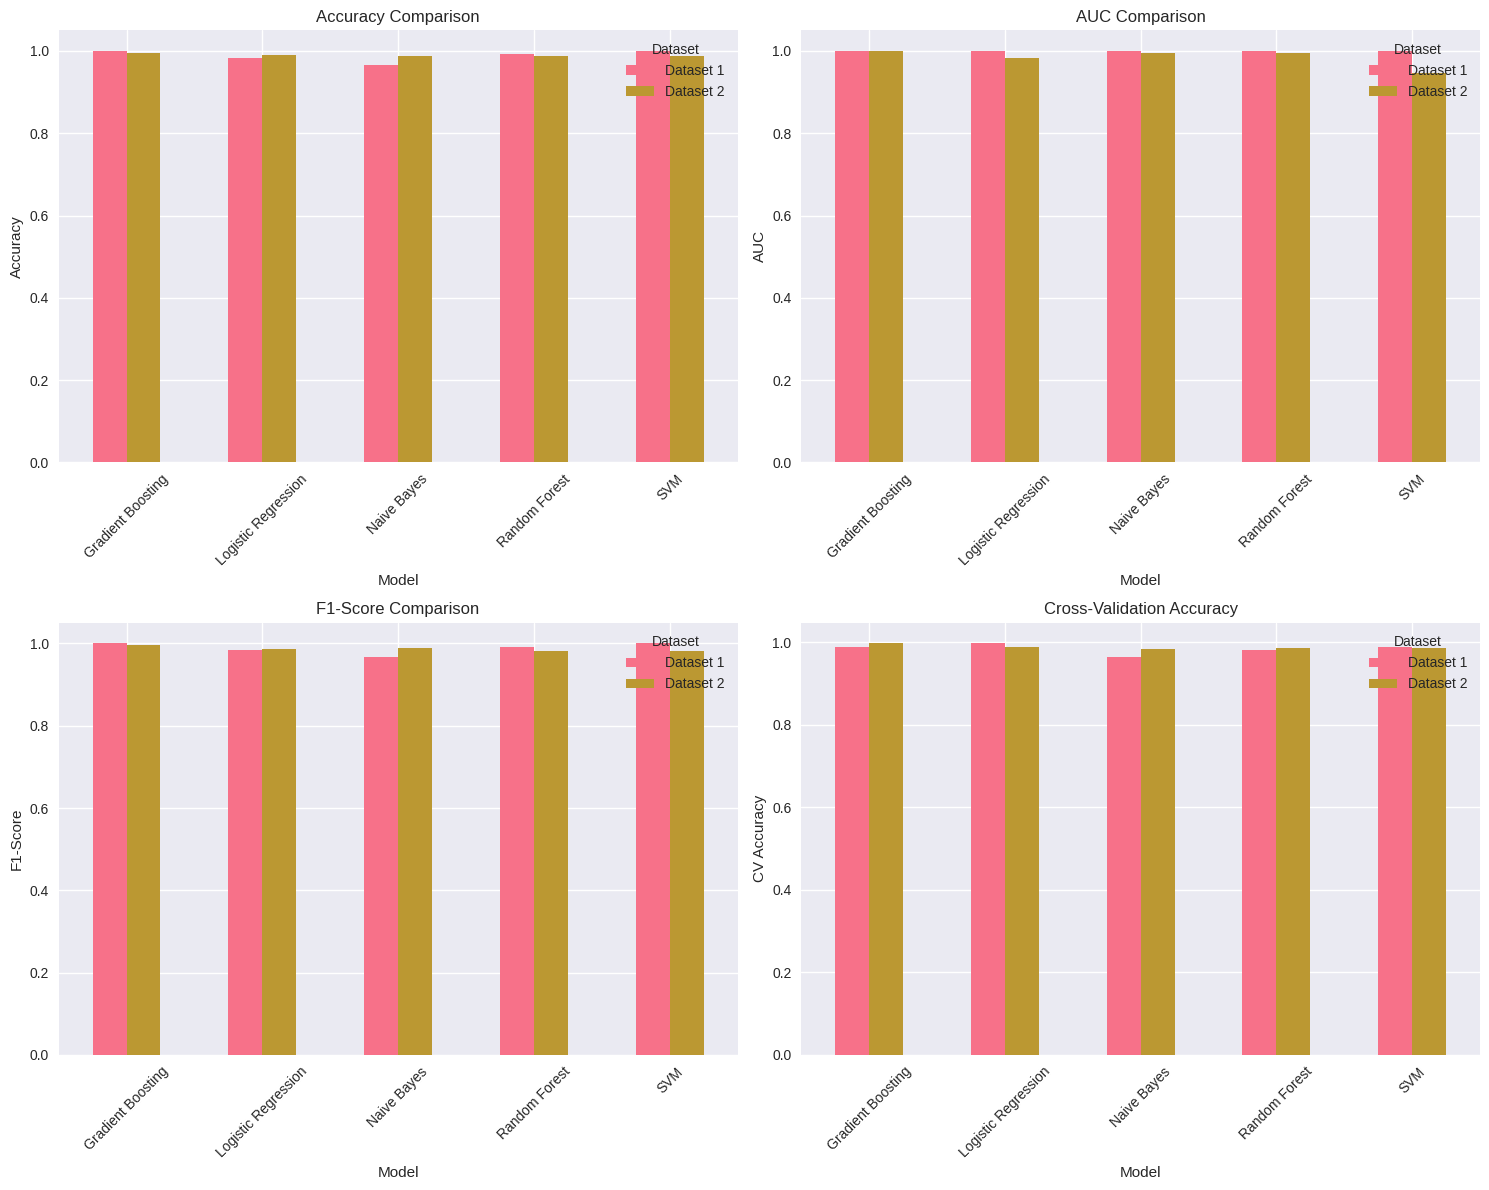

In [12]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Accuracy comparison
pivot_acc = comparison_df.pivot(index='Model', columns='Dataset', values='Accuracy')
pivot_acc.plot(kind='bar', ax=axes[0,0], title='Accuracy Comparison')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend(title='Dataset')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. AUC comparison
pivot_auc = comparison_df.pivot(index='Model', columns='Dataset', values='AUC')
pivot_auc.plot(kind='bar', ax=axes[0,1], title='AUC Comparison')
axes[0,1].set_ylabel('AUC')
axes[0,1].legend(title='Dataset')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. F1-Score comparison
pivot_f1 = comparison_df.pivot(index='Model', columns='Dataset', values='F1-Score')
pivot_f1.plot(kind='bar', ax=axes[1,0], title='F1-Score Comparison')
axes[1,0].set_ylabel('F1-Score')
axes[1,0].legend(title='Dataset')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Cross-validation scores
pivot_cv = comparison_df.pivot(index='Model', columns='Dataset', values='CV Mean')
pivot_cv.plot(kind='bar', ax=axes[1,1], title='Cross-Validation Accuracy')
axes[1,1].set_ylabel('CV Accuracy')
axes[1,1].legend(title='Dataset')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 11. Overfitting Analysis and Recommendations

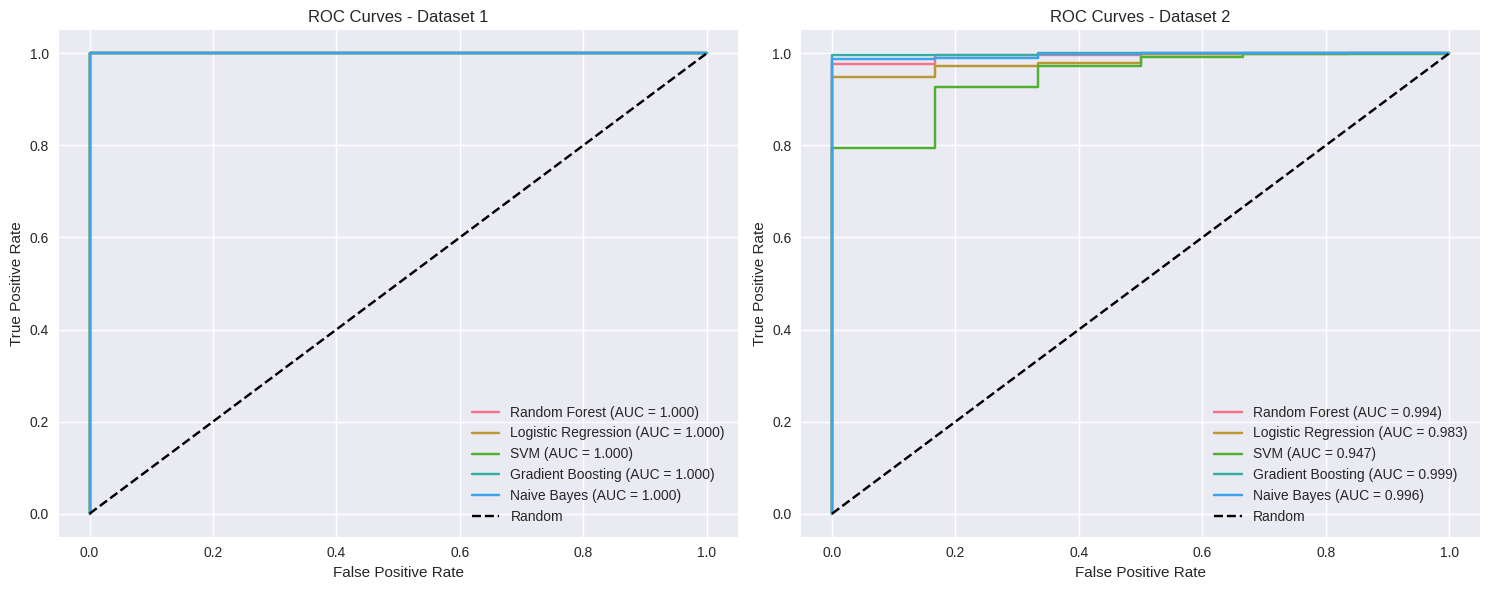

In [13]:
# ROC Curves for both datasets
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Dataset 1 ROC curves
for name, result in results1.items():
    fpr, tpr, _ = roc_curve(result['y_test'], result['y_pred_proba'])
    axes[0].plot(fpr, tpr, label=f"{name} (AUC = {result['auc']:.3f})")

axes[0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves - Dataset 1')
axes[0].legend()
axes[0].grid(True)

# Dataset 2 ROC curves
for name, result in results2.items():
    fpr, tpr, _ = roc_curve(result['y_test'], result['y_pred_proba'])
    axes[1].plot(fpr, tpr, label=f"{name} (AUC = {result['auc']:.3f})")

axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves - Dataset 2')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 12. Final Recommendations and Model Saving

In [14]:
# Recommendations
print("\n" + "-"*50)
print("RECOMMENDATIONS")
print("-"*50)

best_overall_model = model_ranking.index[0]
best_dataset = dataset_avg.mean(axis=1).idxmax()

print(f"\n1. Best Overall Model: {best_overall_model}")
print(f"   - Consistently performs well across both datasets")
print(f"   - Average performance score: {model_ranking.iloc[0]['Average']:.4f}")

print(f"\n2. Best Dataset: {best_dataset}")
print(f"   - Models generally perform better on this dataset")
print(f"   - Consider using this dataset for production deployment")

print(f"\n3. Model Deployment Recommendations:")
print(f"   - Primary model: {best_overall_model} trained on {best_dataset}")
print(f"   - Consider ensemble methods combining top 3 models")
print(f"   - Implement cross-validation in production for robust performance")

# Save comparison report
comparison_df.to_csv('model_comparison_report.csv', index=False)
print(f"\n4. Report saved as 'model_comparison_report.csv'")

# Save best models
os.makedirs('saved_models', exist_ok=True)

# Find best model for each dataset
best_model_d1 = comparison_df[comparison_df['Dataset'] == 'Dataset 1'].loc[comparison_df[comparison_df['Dataset'] == 'Dataset 1']['AUC'].idxmax()]['Model']
best_model_d2 = comparison_df[comparison_df['Dataset'] == 'Dataset 2'].loc[comparison_df[comparison_df['Dataset'] == 'Dataset 2']['AUC'].idxmax()]['Model']

# Save best models
joblib.dump(results1[best_model_d1]['model'], f'saved_models/best_model_dataset1_{best_model_d1.replace(" ", "_").lower()}.pkl')
joblib.dump(results2[best_model_d2]['model'], f'saved_models/best_model_dataset2_{best_model_d2.replace(" ", "_").lower()}.pkl')

# Save scalers
joblib.dump(scaler1, 'saved_models/scaler_dataset1.pkl')
joblib.dump(scaler2, 'saved_models/scaler_dataset2.pkl')

print(f"\nBest models saved:")
print(f"Dataset 1: {best_model_d1} (AUC: {results1[best_model_d1]['auc']:.4f})")
print(f"Dataset 2: {best_model_d2} (AUC: {results2[best_model_d2]['auc']:.4f})")
print(f"\nAll models and scalers saved in 'saved_models/' directory")

print("\n" + "="*80)
print("COMPREHENSIVE MODEL TRAINING AND EVALUATION COMPLETED!")
print("="*80)
print("\nSUMMARY:")
print(f"- Trained 5 ML models on 2 datasets (10 total model-dataset combinations)")
print(f"- Best overall model: {best_overall_model}")
print(f"- Best performing dataset: {best_dataset}")
print(f"- Comprehensive comparison report saved")
print(f"- Best models saved for deployment")


--------------------------------------------------
RECOMMENDATIONS
--------------------------------------------------

1. Best Overall Model: Gradient Boosting
   - Consistently performs well across both datasets
   - Average performance score: 0.9984

2. Best Dataset: Dataset 1
   - Models generally perform better on this dataset
   - Consider using this dataset for production deployment

3. Model Deployment Recommendations:
   - Primary model: Gradient Boosting trained on Dataset 1
   - Consider ensemble methods combining top 3 models
   - Implement cross-validation in production for robust performance

4. Report saved as 'model_comparison_report.csv'

Best models saved:
Dataset 1: Random Forest (AUC: 1.0000)
Dataset 2: Gradient Boosting (AUC: 0.9986)

All models and scalers saved in 'saved_models/' directory

COMPREHENSIVE MODEL TRAINING AND EVALUATION COMPLETED!

SUMMARY:
- Trained 5 ML models on 2 datasets (10 total model-dataset combinations)
- Best overall model: Gradient Boost